# Ranking metrics present in *benchscofi*

We test different accuracy and ranking metrics, and the impact of random (*versus* weakly correlated) splitting into training and testing datasets, across datasets (*e*.*g*., using the real-life dataset ``TRANSCRIPT``).

--------------------------------------------------------
### Table of contents

- [1. Parameters](#1.-Parameters)
- [2. Example of pipeline for training a single model on a single dataset](#2.-Example-of-pipeline-for-training-a-single-model-on-a-single-dataset)
- [3. Ranking metrics](#3.-Ranking-metrics)
    + [3.1 DCG / NCDG](#3.1-DCG-/-NCDG)
    + [3.2 Mean reciprocal rank (MRR)](#3.2-Mean-reciprocal-rank-(MRR))
    + [3.3 R Precision](#3.3-R-Precision)
    + [3.4 Precision @ k](#3.4-Precision-@-k)
    + [3.5 Average Precision (AP)](#3.5-Average-Precision-(AP))
    + [3.6 Mean Average Precision (mAP)](#3.6-Mean-Average-Precision-(mAP))
    + [3.7 Label ranking average precision (LRAP)](#3.7-Label-ranking-average-precision-(LRAP))
    + [3.8 Kendall's $\tau$](#3.8-Kendall's-$\tau$)
    + [3.9 Spearman's $r$](#3.9-Spearman's-$r$)
    + [3.10 Expected reciprocal rank (ERR)](#3.10-Expected-reciprocal-rank-(ERR))
- [4. Test with libmf](#4.-Test-with-libmf)
    + [4.1 Create inputs](#4.1-Create-inputs)
    + [4.2 One class matrix factorization (OCMF)](#4.2-One-class-matrix-factorization-(OCMF))
        - [4.2.a Using a stochastic gradient method](#4.2.a-Using-a-stochastic-gradient-method)
--------------------------------------------------------

In [2]:
from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset
from stanscofi.training_testing import weakly_correlated_split, random_simple_split, cv_training
from stanscofi.validation import compute_metrics, plot_metrics, metrics_list
import stanscofi.validation

from glob import glob
from time import time
import numpy as np
import pandas as pd

import sys #
sys.path.insert(0,"../src/") #
import benchscofi

dataset_folder="../datasets/"
! mkdir -p "../datasets/"
! pip install -q stanscofi==2.0.0
! pip freeze | grep "stanscofi"

stanscofi==2.0.0


## 1. Parameters

In [3]:
random_state = 1234
decision_threshold=0

########################
## Dataset parameters ##
########################
dataset_names = ["TRANSCRIPT"]
split_params = {"metric": "cosine", "test_size": 0.2, "split_randomly": True}

##########################
## Algorithm parameters ##
##########################
algo_params = {
    "PMF": {
        'reg': 0.01,
        'learning_rate': 0.5,
        'n_iters': 160,
        'n_factors': 15,
        'batch_size': 100,
    },
}

## 2. Example of pipeline for training a single model on a single dataset

----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 180 drugs and 101 diseases involved in at least one positive/negative rating
321 positive, 9 negative, 92233 unlabeled (including 18513 unavailable) drug-disease ratings
Sparsity: 0.36 percent (on drugs/diseases with at least one known rating 1.82)
-----------------------------------
* Feature matrices:
#Drug features: 12096	Total #Drugs: 613
Missing features: 0.00 percent
#Disease features: 12096	Total #Disease: 151
Missing features: 0.00 percent
----------------------------------------------------------------------

----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 63 drugs and 58 diseases involved in at least one positive/negative rating
80 positive, 2 negative, 92481 unlabeled (including 74050 unavailable) drug-disease ratings
Sparsity: 0.09 percent (on drugs/diseases with at least one kno

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
2023-08-02 04:00:47.032738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 04:00:47.048985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 04:00:47.048985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compi

<validation.compute_metrics> Computed on #users=151, 67 ignored (44 perc)
<validation.compute_metrics> Computed on #users=151, 109 ignored (72 perc)
Crossvalidation step #2/5 (train AUC 0.750491, test AUC 0.609957)


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.3s finished


* Scores
613 unique items, 151 unique users
Scores: Min: -13.696139	Mean: 0.003143	Median: 0.012723	Max: 15.087838	Std: 2.696024

* Classification
613 unique items, 151 unique users
Positive class: 9298, Negative class: 9215

<validation.compute_metrics> Computed on #users=151, 94 ignored (62 perc)


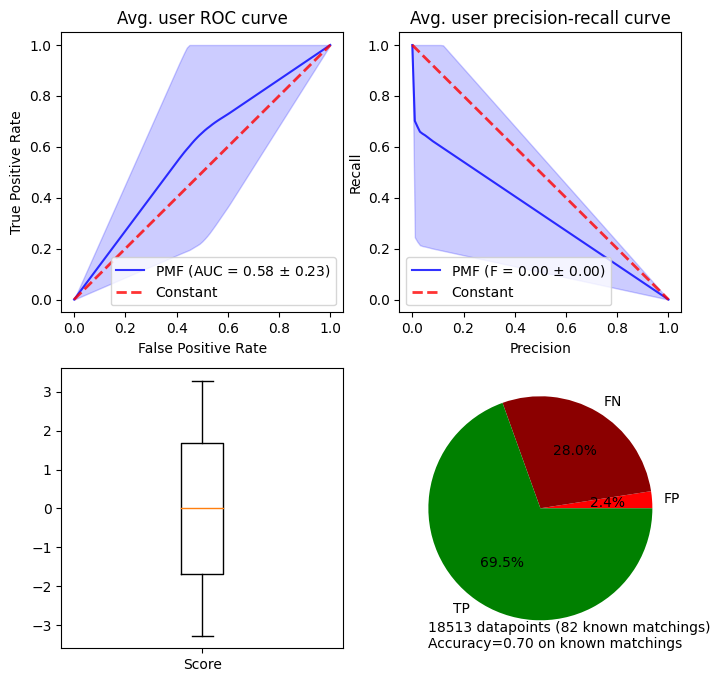

Value    Average  StandardDeviation
AUC                   0.704159   0.582821           0.225721
Rscore                0.029750   0.039749           0.090071
MRR                   0.083333   0.054633           0.087174
RP                    0.000866   0.031445           0.029384
PrecisionK            0.000000   0.017544           0.056577
RecallK               0.000000   0.035673           0.120567
F1K                   0.000000   0.022932           0.074624
AP                    0.018041   0.042079           0.050244
MAP                   0.018041   0.042079           0.050244
DCGk                  0.000000   0.051280           0.177933
NDCGk                 0.000000   0.020888           0.069209
MeanRank             12.000000  52.561404          35.096867
HRk                   0.000000   0.087719           0.282886
ERR                   0.000000   0.009367           0.026198
Fscore                     NaN   0.000563           0.001079
TAU                        NaN   0.039749           0.090071
arguments (k, beta)        NaN   5.000000           1.000000

In [4]:
def training_testing(dataset_name, split_params, algo, params, random_state, decision_threshold, k, beta):
    #############
    ## Dataset ##
    #############
    dataset_di = load_dataset(dataset_name, dataset_folder)
    dataset_di.setdefault("same_item_user_features", dataset_name=="TRANSCRIPT")
    dataset_di.setdefault("name", dataset_name)
    dataset = Dataset(**dataset_di)

    ############################
    ## Weakly correlated sets ##
    if (not split_params["split_randomly"]):
        (train_folds, test_folds), _ = weakly_correlated_split(dataset, split_params["test_size"], early_stop=1, 
                                                            metric=split_params["metric"], verbose=True)
    ######################
    ## Random splitting ##
    else:
        (train_folds, test_folds), _ = random_simple_split(dataset, split_params["test_size"], 
                                                               metric=split_params["metric"])

    train_dataset = dataset.subset(train_folds, subset_name="Train_"+dataset_name)
    test_dataset = dataset.subset(test_folds, subset_name="Test_"+dataset_name)

    train_dataset.summary()
    test_dataset.summary()

    ###############
    ## Algorithm ##
    ###############
    __import__("benchscofi."+algo)
    model = eval("benchscofi."+algo+"."+algo)(algo_params[algo])

    ###############
    ## Training  ##
    ###############
    #model.fit(train_dataset, random_state)
    ######################
    ## Cross-validation ##
    results = cv_training(eval("benchscofi."+algo+"."+algo), params, train_dataset, 
        threshold=decision_threshold, metric="AUC", k=k, beta=beta, njobs=4, 
        nsplits=5, random_state=random_state, show_plots=False, verbose=True,
        cv_type="random" if (split_params["split_randomly"]) else "weakly_correlated")
    model = results["models"][np.argmax(results["test_metric"])]

    #################
    ## Predictions ##
    #################
    scores = model.predict_proba(test_dataset)
    predictions = model.predict(scores, threshold=decision_threshold)

    model.print_scores(scores)
    model.print_classification(predictions)

    #################
    ## Validation  ##
    #################

    ## disease-wise metrics
    metrics, plot_args = compute_metrics(scores, predictions, test_dataset, metrics=metrics_list,
                                         k=k,beta=beta,verbose=1)
    plot_args.update({"model_name": "PMF", "figsize": (8,8)})
    plot_metrics(**plot_args)

    ## dataset-wide metrics
    y_test = (test_dataset.folds.toarray()*test_dataset.ratings.toarray()).ravel()
    y_test[y_test<1] = 0

    whole_metrics = [
            eval("stanscofi.validation."+metric)(y_test, scores.toarray().ravel(), 5, 1)
            for metric in metrics_list if (metric not in ["Fscore", "TAU"])
    ]

    results = pd.concat(
    (pd.DataFrame([whole_metrics], index=["Value"], columns=[m for m in metrics_list if (m not in ["Fscore","TAU"])]).T,
     metrics), axis=1
    )
    
    return results

## Call
training_testing(
    dataset_names[0], 
    split_params, 
    [a for a in algo_params][0], 
    algo_params[[a for a in algo_params][0]], 
    random_state, 
    decision_threshold, 
    5, 1
)

## 3. Ranking metrics

### 3.1 DCG / NCDG

Formula for normalized discounted cumulative gain (NDCG) up to rank $k<N=$\#pairs on the ranking on pairs by *decreasing* predicted score given by the permutation $\sigma : \{p_1,p_2,\dots,p_k,p_{k+1},\dots,p_N\} \rightarrow [N]=\{1,2,\dots,N\}$, and the list of true scores $t : \{p_1,p_2,\dots,p_k\} \rightarrow \mathbb{R}$ corresponding to the ideal permutation $\sigma^\star$ (such that $(\sigma^\star)^{-1}(1) = \arg\max_{i}t(p_i)$, $\dots$, $(\sigma^\star)^{-1}(N)=\arg\min_{i}t(p_i)$):

$$ \text{nDCG}_k(\sigma,t) := \underbrace{\sum_{i=1}^k \frac{t[\sigma^{-1}(i)]}{\log_2(i+1)}}_\text{DCG$_k(\sigma,t)$} / \underbrace{\sum_{j=1}^k \frac{t[(\sigma^\star)^{-1}(j)]}{\log_2(j+1)}}_\text{ideal DCG$_k(\sigma,t)$=DCG$_k(\sigma^\star,t)$}\;.$$

**Notation:** Let us consider the ranking on $N$ pairs by *decreasing* predicted score identified by $\{1,2,\dots,N\}$ given by permutation $\sigma : \{p_1,p_2,\dots,p_k,p_{k+1},\dots,p_N\} \rightarrow [N]=\{1,2,\dots,N\}$, and the list of true scores $t : \{p_1,p_2,\dots,p_k\} \rightarrow \mathbb{R}$. $N_\text{pos}$ is the number of positive pairs among the $N$ ones.

### 3.2 Mean reciprocal rank (MRR)

Here, we only perform one ''query'' (retrieve a positive pair) and as such, the corresponding rank of the correct answer in our case is the minimum rank of a positive pair in the ranking by predicted scores:

$$ \text{MRR}(\sigma,t) := \arg\min_{\substack{r \in [N]\\t[\sigma^{-1}(r)]=1}} 1/r\;.$$

### 3.3 R-Precision

$$ \text{RP}(\sigma,t) := \frac{\sum_{r=1}^{N_\text{pos}} \delta(t[\sigma^{-1}(r)]=1)}{N_\text{pos}}\;.$$

### 3.4 Precision @ k

$$ \text{Prec@}k(\sigma,t) := \frac{\sum_{r=1}^{k} \delta(t[\sigma^{-1}(r)]=1)}{k}\;.$$

### 3.5 Average Precision (AP)

$$ \text{AP}(\sigma,t) := \frac{1}{N_\text{pos}}\sum_{r=1}^{N_\text{pos}}\text{Prec@}r(\sigma,t)\;.$$

### 3.6 Mean Average Precision (mAP)

Since we only have one class, in our case mAP=AP.

### 3.7 Label ranking average precision (LRAP)

**Notation:** Let us consider $N$ pairs, and the ground truth for pair $i \leq N$ $y_i \in \{0,1\}^2$ ($\|y_i\|_0=1$) and the corresponding predicted score $\hat{y}_i \in [0,1]^2$ ($\|\hat{y}_i\|_1=1$), since, in our case, there is only one single class.

$$\text{LRAP}(p,t) := \frac{1}{N}\sum_{i=1}^N \frac{1}{1+\delta(\hat{y}_i[0]\geq \hat{y}_i[1])}\;.$$

### 3.8 Kendall's $\tau$

If $N_\text{dis}$ is the number of discordant pairs between predicted scores $p$ and true labels $t$ (i.e., $(i,j)$ such that $p[i]<p[j] \land t[i]>t[j]$ or $p[j]<p[i] \land t[j]>t[i]$)

$$\tau(p,t) = 1 - \frac{2N_\text{dis}(p,t)}{C^n_2}\;.$$

A smarter version is implemented in ``scipy`` which takes into account ties.

### 3.9 Spearman's $r$

Roughly Pearson correlation on ranks instead of scores.

### 3.10 Expected reciprocal rank (ERR)

Here, we consider a single query (find one positive pair). If $\sigma$ is the ranking induced by decreasing predicted scores and $t$ the true binary labels on $N$ pairs. This is supposed to introduce some dependency with prior elements encountered in the ranking [[ref]](https://dl.acm.org/doi/abs/10.1145/1645953.1646033)

$$\text{ERR} := \sum_{k=1}^N \frac{1}{k}t[\sigma^{-1}(k)]\Pi_{i=1}^{k-1}(1-t[\sigma^{-1}(i)])\;.$$

## 4. Test with *libmf*

In [12]:
from subprocess import Popen
! if [ ! -d "libmf/" ]; then git clone -q https://github.com/jilljenn/libmf.git; fi
! if [ ! -s "libmf/mf-train" ] || [ ! -s "libmf/mf-predict" ]; then (cd "libmf/" && make); fi

g++ -Wall -O3 -pthread -std=c++0x -march=native -fopenmp -DUSESSE -DUSEOMP -c -fPIC -o mf.o mf.cpp
g++ -Wall -O3 -pthread -std=c++0x -march=native -fopenmp -DUSESSE -DUSEOMP -o mf-train mf-train.cpp mf.o
g++ -Wall -O3 -pthread -std=c++0x -march=native -fopenmp -DUSESSE -DUSEOMP -o mf-predict mf-predict.cpp mf.o


### 4.1 Create inputs

Create the dataset, split into training/testing and validation datasets:

In [13]:
#############
## Dataset ##
#############
dataset_name = dataset_names[0]

dataset_di = load_dataset(dataset_name, dataset_folder)
dataset_di.setdefault("same_item_user_features", dataset_name=="TRANSCRIPT")
dataset_di.setdefault("name", dataset_name)
dataset = Dataset(**dataset_di)

############################
## Weakly correlated sets ##
if (not split_params["split_randomly"]):
    (train_folds, test_folds), _ = weakly_correlated_split(dataset, split_params["test_size"], early_stop=1, 
                                                        metric=split_params["metric"], verbose=True)
######################
## Random splitting ##
else:
    (train_folds, test_folds), _ = random_simple_split(dataset, split_params["test_size"], 
                                                           metric=split_params["metric"])
    
from stanscofi.training_testing import random_cv_split
from sklearn.model_selection import StratifiedKFold
cv_generator = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
train_dataset = dataset.subset(train_folds)
cv_folds, _ = stanscofi.training_testing.random_cv_split(train_dataset, cv_generator, metric="euclidean")

Convert into files readable by *libFM*

In [14]:
## NDGC code from libmf

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score, roc_auc_score
from collections import Counter
import sys

def execute_ndcg(trainfile, testfile, outfiles):
    df_train = pd.read_csv(trainfile, sep=' ', names=('user', 'item', 'v'))
    df = pd.read_csv(testfile, sep=' ', names=('user', 'item', 'v'))
    df['user_id'] = np.unique(df['user'], return_inverse=True)[1]
    df['item_id'] = np.unique(df['item'], return_inverse=True)[1]
    encode_user = dict(df[['user', 'user_id']].drop_duplicates().to_numpy())
    encode_item = dict(df[['item', 'item_id']].drop_duplicates().to_numpy())
    df_train['user_id'] = df_train['user'].map(encode_user)
    df_train['item_id'] = df_train['item'].map(encode_item)

    n_users = df['user'].nunique()
    n_items = df['item'].nunique()
    n_entries, _ = df.shape
    print(n_users, df['user_id'].max())
    print(n_items, df['item_id'].max())
    truth = csr_matrix((df['v'] * n_entries, (df['user_id'], df['item_id'])), shape=(n_users, n_items))

    for filename in outfiles:
        out = pd.read_csv(filename, names=('pred',))
        print(filename, out.shape, df['user_id'].shape)
        sparse = csr_matrix((out['pred'], (df['user_id'], df['item_id'])), shape=(n_users, n_items))

        ndcg_values = []
        ndcg10_values = []
        auc_values = []
        for user_id in df['user_id'].unique():
            test_set = list(set(range(n_items)) - set(df_train.query("user_id == @user_id")['item_id'].tolist()))
            # print(n_items - len(test_set))
            user_truth = truth[user_id, test_set].toarray()
            # print(Counter(user_truth.reshape(-1).tolist()))
            user_pred = sparse[user_id, test_set].toarray()
            ndcg_values.append(ndcg_score(user_truth, user_pred))
            ndcg10_values.append(ndcg_score(user_truth, user_pred, k=10))
            try:
                auc_values.append(roc_auc_score(user_truth.reshape(-1),
                                            user_pred.reshape(-1)))
            except ValueError as e:
                print(e)
                print(df.query("user_id == @user_id").shape)
                print(df.query("user_id == @user_id and v == 1"))
                print(df_train.query("user_id == @user_id"))
                print(user_id, len(test_set), Counter(user_truth.tolist()[0]))
                break
                continue
        print(filename)
        print('ndcg =', np.mean(ndcg_values))
        print('ndcg@10 =', np.mean(ndcg10_values))
        print('auc =', np.mean(auc_values))
        return np.mean(ndcg_values), np.mean(ndcg10_values), np.mean(auc_values)

### 4.2 One-class matrix factorization (OCMF)

#### 4.2.a Using a stochastic gradient method

/!\ not reproducible (no random seed can be provided)

In [15]:
model_file = "libmf/ocmf_model.txt"

params_SGD = {
    'f': 10, # loss function: row-oriented pair-wise logarithmic loss
    'l2': 0.01, # L2-regularization parameter
    'k': 32, # number of dimensions
    "t": 20, # number of iterations
    "s": 10, # number of threads
    "r": 0.5, # initial learning rate
}

###############
## Training  ##
# In-memory training with holdout validation

perf_folds = []

for i, (train_folds_random_cv, test_folds_random_cv) in enumerate(cv_folds):
    
    for ii, folds in enumerate([train_folds_random_cv, test_folds_random_cv]): 
        sb_dt = train_dataset.subset(folds)
        rats = ( sb_dt.ratings.toarray()[sb_dt.folds.toarray()>0] ).ravel()
        mat = np.column_stack((sb_dt.folds.row, sb_dt.folds.col, rats))
        mat = mat[mat[:,-1]>0]
        np.savetxt(("libmf/all_one_matrix_i%d.tr.txt"
                   if (not ii) else "libmf/all_one_matrix_i%d.te.txt") % (i+1), 
                   mat, fmt='%d')
        y_test = (sb_dt.folds.toarray()*sb_dt.ratings.toarray()).ravel()
        y_test[y_test<1] = 0
 
    cmd = "libmf/mf-train -f %d -l2 %f -k %d -t %d -s %d -c %f -p %s %s %s" % tuple(
        [params_SGD[x] for x in ["f","l2","k","t","s",'r']]
                +[
                     "libmf/all_one_matrix_i%d.te.txt" % (i+1),
                      "libmf/all_one_matrix_i%d.tr.txt" % (i+1), 
                      "libmf/ocmf_model_SGD_i%d.txt" % (i+1)
                    ])
    #print(cmd)
    process = Popen(cmd.split(" "))
    process.wait()
    
    ev=0
    cmd = "libmf/mf-predict -e %d %s %s libmf/ocmf_output_SGD_e%d_i=%d.txt" % (
        ev, "libmf/all_one_matrix_i%d.te.txt" % (i+1), "libmf/ocmf_model_SGD_i%d.txt" % (i+1), ev, i+1
    )
    #print(cmd)
    process = Popen(cmd.split(" "))
    process.wait()
    
    ## Whole dataset metrics
    scores = np.loadtxt("libmf/ocmf_output_SGD_e%d_i=%d.txt" % (ev, i+1))
    preds = np.zeros(y_test.shape)
    preds[y_test==1] = scores
    pref_fold = stanscofi.validation.AUC(y_test, preds, 0, 0)
    
    ## Row-wise metrics
    _, _, rowauc = execute_ndcg("libmf/all_one_matrix_i%d.tr.txt" % (i+1), 
            "libmf/all_one_matrix_i%d.te.txt" % (i+1), ["libmf/ocmf_output_SGD_e%d_i=%d.txt" % (ev, i+1)])
    
    sb_dt = train_dataset.subset(test_folds_random_cv)
    from stanscofi.validation import compute_metrics 
    from scipy.sparse import coo_array
    preds = np.zeros(sb_dt.folds.shape)
    preds[sb_dt.folds.row,sb_dt.folds.col] = 1e-32
    preds = preds.ravel()
    preds[y_test==1] = [max(1e-32,s) for s in scores]
    preds = coo_array(preds.reshape(sb_dt.folds.shape))
    predictions = np.zeros(sb_dt.folds.shape)
    predictions[sb_dt.folds.row,sb_dt.folds.col] = -1
    predictions = predictions.ravel()
    predictions[y_test==1] = [(-1)**(max(1e-32,s)<0) for s in scores]
    predictions = coo_array(predictions.reshape(sb_dt.folds.shape))
    y_pred_all = predictions.data.ravel()
    scores_all = preds.data.ravel()
    y_true_all = sb_dt.ratings.toarray()[sb_dt.folds.row,sb_dt.folds.col].ravel() 
    metrics, _ = compute_metrics(preds, predictions, sb_dt, metrics=["AUC"], k=1, beta=1, verbose=False)

    print("------- METRICS")
    e=[12,13]
    for ev in e:
        cmd = "libmf/mf-predict -e %d %s %s libmf/ocmf_output_SGD_e%d_i=%d.txt" % (
            ev, "libmf/all_one_matrix_i%d.te.txt" % (i+1), "libmf/ocmf_model_SGD_i%d.txt" % (i+1), ev, i+1
        )
        #print(cmd)
        process = Popen(cmd.split(" "))
        process.wait()
    print("(rowwise stanscofi) AUC = %.3f" % metrics.values[0,0])
    print("(rowwise code) AUC = %.3f" % rowauc)
    print("(global) AUC = %.3f" % pref_fold)
    print("---------------")
    
    process = Popen((
      "rm -f libmf/all_one_matrix_i=%d.tr.txt libmf/all_one_matrix_i=%d.te.txt libmf/ocmf_output_SGD_e%d_i=%d.txt" 
                     % (i+1,i+1, ev,i+1)).split(" "))
    process.wait()
    
    perf_folds.append(pref_fold)

perf_folds

iter   tr_bprloss   va_bprloss          obj
   0       0.6534       0.6830   1.6865e+02
   1       0.6301       0.6727   1.6322e+02
   2       0.6020       0.6513   1.5661e+02
   3       0.5822       0.6330   1.5205e+02
   4       0.5696       0.6446   1.4922e+02
   5       0.5369       0.6497   1.4134e+02
   6       0.5114       0.6399   1.3530e+02
   7       0.5034       0.6434   1.3354e+02
   8       0.4815       0.6217   1.2903e+02
   9       0.4681       0.6272   1.2601e+02
  10       0.4278       0.5662   1.1622e+02
  11       0.4136       0.6525   1.1295e+02
  12       0.4072       0.5792   1.1161e+02
  13       0.3895       0.6088   1.0764e+02
  14       0.3844       0.5435   1.0655e+02
  15       0.3729       0.5404   1.0390e+02
  16       0.3746       0.5769   1.0448e+02
  17       0.3748       0.6177   1.0483e+02
  18       0.3529       0.6519   9.9501e+01
  19       0.3549       0.5915   1.0020e+02
RMSE = 1.2103
51 50
45 44
libmf/ocmf_output_SGD_e0_i=1.txt (65, 1) (65,)
lib

[0.6846153846153846, 0.625, 0.7265625, 0.71875, 0.7109375]

In [16]:
################
## Validation ##
e = [10, 12] # evaluation criterion: row-oriented mean percentile rank, row-oriented area under ROC curve

## best model
best_i = np.argmax(perf_folds)

for i in range(5):
    if (i!=best_i):
        process = Popen((
            "rm -f libmf/ocmf_model_SGD_i%d.txt" % (i+1)).split(" "))
        process.wait()

# Do prediction and show evaluation value ev
for ev in e:
    print("-"*24)
    print("row-oriented mean percentile rank" if (ev==10) else "row-oriented area under ROC curve")
    
    cmd = "libmf/mf-predict -e %d %s %s libmf/ocmf_output_SGD_e%d_i=%d.txt" % (
        ev, "libmf/all_one_matrix_i%d.te.txt" % (best_i+1), 
        "libmf/ocmf_model_SGD_i%d.txt" % (best_i+1), ev, best_i+1
    )
    #print(cmd)
    process = Popen(cmd.split(" "))
    process.wait()
    
    ## Row-wise metrics
    execute_ndcg("libmf/all_one_matrix_i%d.tr.txt" % (best_i+1), "libmf/all_one_matrix_i%d.te.txt" % (best_i+1), 
                 ["libmf/ocmf_output_SGD_e%d_i=%d.txt" % (ev, best_i+1)])
    
for i in range(5):
    if (i!=best_i):
        process = Popen((
            "rm -f libmf/all_one_matrix_i%d.tr.txt libmf/all_one_matrix_i%d.te.txt" % (i+1, i+1)).split(" "))
        process.wait()

------------------------
row-oriented mean percentile rank
Row-wise MPR = 0.5204
48 47
39 38
libmf/ocmf_output_SGD_e10_i=3.txt (64, 1) (64,)
libmf/ocmf_output_SGD_e10_i=3.txt
ndcg = 0.6205543190387875
ndcg@10 = 0.5299754164332496
auc = 0.6840277777777777
------------------------
row-oriented area under ROC curve
Row-wise AUC = 0.3942
48 47
39 38
libmf/ocmf_output_SGD_e12_i=3.txt (64, 1) (64,)
libmf/ocmf_output_SGD_e12_i=3.txt
ndcg = 0.6205543190387875
ndcg@10 = 0.5299754164332496
auc = 0.6840277777777777


#### 4.2.b Using a coordinate descent method

In [17]:
params_CD = {
    'f': 12, # loss function: squared error (L2-norm)
    'l2': 0.01, # L2-regularization parameter
    'k': 32, # number of dimensions
    "a": 0.001, # coefficient of negative entries' loss
    "s": 10, # number of threads
    "c": 0.0001, # value of negative entries
}

###############
## Training  ##
# In-memory training with holdout validation

perf_folds = []

for i, (train_folds_random_cv, test_folds_random_cv) in enumerate(cv_folds):
    
    for ii, folds in enumerate([train_folds_random_cv, test_folds_random_cv]): 
        sb_dt = train_dataset.subset(folds)
        rats = ( sb_dt.ratings.toarray()[sb_dt.folds.toarray()>0] ).ravel()
        mat = np.column_stack((sb_dt.folds.row, sb_dt.folds.col, rats))
        mat = mat[mat[:,-1]>0]
        np.savetxt(("libmf/all_one_matrix_i%d.tr.txt"
                   if (not ii) else "libmf/all_one_matrix_i%d.te.txt") % (i+1), 
                   mat, fmt='%d')
        y_test = (sb_dt.folds.toarray()*sb_dt.ratings.toarray()).ravel()
        y_test[y_test<1] = 0
 
    cmd = "libmf/mf-train -f %d -l2 %f -k %d -a %f -s %d -c %f -p %s %s %s" % tuple(
        [params_CD[x] for x in ["f","l2","k","a","s",'c']]
                +[
                     "libmf/all_one_matrix_i%d.te.txt" % (i+1),
                      "libmf/all_one_matrix_i%d.tr.txt" % (i+1), 
                      "libmf/ocmf_model_CD_i%d.txt" % (i+1)
                    ])
    #print(cmd)
    process = Popen(cmd.split(" "))
    process.wait()
    
    ev=0
    cmd = "libmf/mf-predict -e %d %s %s libmf/ocmf_output_CD_e%d_i=%d.txt" % (
        ev, "libmf/all_one_matrix_i%d.te.txt" % (i+1), "libmf/ocmf_model_CD_i%d.txt" % (i+1), ev, i+1
    )
    #print(cmd)
    process = Popen(cmd.split(" "))
    process.wait()
    
    ## Whole dataset metrics
    scores = np.loadtxt("libmf/ocmf_output_CD_e%d_i=%d.txt" % (ev, i+1))
    preds = np.zeros(y_test.shape)
    preds[y_test==1] = scores
    pref_fold = stanscofi.validation.AUC(y_test, preds, 0, 0)
    
    ## Row-wise metrics
    _, _, rowauc = execute_ndcg("libmf/all_one_matrix_i%d.tr.txt" % (i+1), "libmf/all_one_matrix_i%d.te.txt" % (i+1), 
                 ["libmf/ocmf_output_CD_e%d_i=%d.txt" % (ev, i+1)])
    
    sb_dt = train_dataset.subset(test_folds_random_cv)
    from stanscofi.validation import compute_metrics 
    from scipy.sparse import coo_array
    preds = np.zeros(sb_dt.folds.shape)
    preds[sb_dt.folds.row,sb_dt.folds.col] = 1e-32
    preds = preds.ravel()
    preds[y_test==1] = [max(1e-32,s) for s in scores]
    preds = coo_array(preds.reshape(sb_dt.folds.shape))
    predictions = np.zeros(sb_dt.folds.shape)
    predictions[sb_dt.folds.row,sb_dt.folds.col] = -1
    predictions = predictions.ravel()
    predictions[y_test==1] = [(-1)**(max(1e-32,s)<0) for s in scores]
    predictions = coo_array(predictions.reshape(sb_dt.folds.shape))
    y_pred_all = predictions.data.ravel()
    scores_all = preds.data.ravel()
    y_true_all = sb_dt.ratings.toarray()[sb_dt.folds.row,sb_dt.folds.col].ravel() 
    metrics, _ = compute_metrics(preds, predictions, sb_dt, metrics=["AUC"], k=1, beta=1, verbose=False)
    
    print("------- METRICS")
    e=[12,13]
    for ev in e:
        cmd = "libmf/mf-predict -e %d %s %s libmf/ocmf_output_SGD_e%d_i=%d.txt" % (
            ev, "libmf/all_one_matrix_i%d.te.txt" % (i+1), "libmf/ocmf_model_SGD_i%d.txt" % (i+1), ev, i+1
        )
        #print(cmd)
        process = Popen(cmd.split(" "))
        process.wait()
    print("(rowwise stanscofi) AUC = %.3f" % metrics.values[0,0])
    print("(rowwise code) AUC = %.3f" % rowauc)
    print("(global) AUC = %.3f" % pref_fold)
    print("---------------")
    
    process = Popen((
        "rm -f libmf/all_one_matrix_i=%d.tr.txt libmf/all_one_matrix_i=%d.te.txt libmf/ocmf_output_CD_e%d_i=%d.txt" 
                     % (i+1,i+1, ev,i+1)).split(" "))
    process.wait()
    
    perf_folds.append(pref_fold)

perf_folds

iter   tr_sqerror    tr_sqerror+    tr_sqerror-   va_sqerror    va_sqerror+    va_sqerror-          obj
   0       0.8680         0.0037         0.8644      21.0935        20.1098         0.9836   4.5040e+00
   1       0.4912         0.0027         0.4885      21.2555        20.6458         0.6096   3.8823e+00
   2       0.4110         0.0029         0.4081      20.6747        20.1458         0.5289   3.6053e+00
   3       0.3736         0.0031         0.3705      20.4237        19.9325         0.4912   3.4221e+00
   4       0.3516         0.0032         0.3484      20.2778        19.8088         0.4689   3.2819e+00
   5       0.3389         0.0033         0.3356      20.1898        19.7338         0.4560   3.1696e+00
   6       0.3317         0.0034         0.3283      20.1539        19.7053         0.4486   3.0775e+00
   7       0.3278         0.0034         0.3244      20.1627        19.7180         0.4447   3.0000e+00
   8       0.3266         0.0035         0.3231      20.2004    

   8       0.3408         0.0037         0.3370      18.7641        18.3070         0.4572   3.0406e+00
   9       0.3406         0.0038         0.3368      18.7771        18.3201         0.4569   2.9817e+00
  10       0.3424         0.0038         0.3385      18.8058        18.3471         0.4587   2.9291e+00
  11       0.3455         0.0039         0.3416      18.8452        18.3834         0.4618   2.8816e+00
  12       0.3496         0.0040         0.3456      18.8917        18.4259         0.4658   2.8384e+00
  13       0.3543         0.0040         0.3503      18.9413        18.4708         0.4705   2.7988e+00
  14       0.3592         0.0041         0.3551      18.9901        18.5148         0.4754   2.7624e+00
  15       0.3641         0.0041         0.3600      19.0362        18.5560         0.4802   2.7286e+00
  16       0.3688         0.0041         0.3647      19.0798        18.5948         0.4850   2.6971e+00
  17       0.3735         0.0041         0.3695      19.1209    

[1.0, 0.9765625, 0.96875, 1.0, 1.0]

In [18]:
################
## Validation ##
e = [10, 12] # evaluation criterion: row-oriented mean percentile rank, row-oriented area under ROC curve

## best model
best_i = np.argmax(perf_folds)

for i in range(5):
    if (i!=best_i):
        process = Popen((
            "rm -f libmf/ocmf_model_CD_i%d.txt" % (i+1)).split(" "))
        process.wait()

# Do prediction and show evaluation value ev
for ev in e:
    print("-"*24)
    print("row-oriented mean percentile rank" if (ev==10) else "row-oriented area under ROC curve")
    
    cmd = "libmf/mf-predict -e %d %s %s libmf/ocmf_output_CD_e%d_i=%d.txt" % (
        ev, "libmf/all_one_matrix_i%d.te.txt" % (best_i+1), "libmf/ocmf_model_CD_i%d.txt" % (best_i+1), ev, best_i+1
    )
    #print(cmd)
    process = Popen(cmd.split(" "))
    process.wait()
    
    ## Row-wise metrics
    execute_ndcg("libmf/all_one_matrix_i%d.tr.txt" % (best_i+1), "libmf/all_one_matrix_i%d.te.txt" % (best_i+1), 
                 ["libmf/ocmf_output_CD_e%d_i=%d.txt" % (ev, best_i+1)])
    
for i in range(5):
    if (i!=best_i):
        process = Popen((
            "rm -f libmf/all_one_matrix_i%d.tr.txt libmf/all_one_matrix_i%d.te.txt" % (i+1, i+1)).split(" "))
        process.wait()

------------------------
row-oriented mean percentile rank
Row-wise MPR = 0.2951
51 50
45 44
libmf/ocmf_output_CD_e10_i=1.txt (65, 1) (65,)
libmf/ocmf_output_CD_e10_i=1.txt
ndcg = 1.0
ndcg@10 = 1.0
auc = 1.0
------------------------
row-oriented area under ROC curve
Row-wise AUC = 0.6996
51 50
45 44
libmf/ocmf_output_CD_e12_i=1.txt (65, 1) (65,)
libmf/ocmf_output_CD_e12_i=1.txt
ndcg = 1.0
ndcg@10 = 1.0
auc = 1.0
